In [174]:
import openeo
from matplotlib import pyplot as plt
import rasterio.plot
import io
import tarfile
import numpy as np
import glob
import re
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

In [175]:
main_dir='/cloud/skogsstyrelsen_1c/'
directories=os.listdir(main_dir)
directories

['0316fae7-d2c1-40b7-b6b1-572503129723',
 '124c5465-43c0-4b8b-a624-f78a237a4a55',
 '307f0810-6f13-4bde-b88c-b9eaf8ce5d25',
 '3b208f65-cf77-4349-9708-a9a4fc06f5d8',
 '3b9b0586-98ce-4603-bd8b-a81423647b70',
 '43ab4c4c-310b-44ae-9548-e09017656537',
 '48948379-d614-4be8-a319-8174a15875e0',
 '5f22ce6c-8d7d-438f-ab05-bd043a708e82',
 '6061d236-faf2-4e6f-83cb-3fdda8451144',
 '68dbadbe-22e8-4839-afa9-b6dbe8331b22',
 '783b6f31-d468-4a86-802d-41b2c8df9bc2',
 '7e2fa848-3d2a-4eb4-99b6-4ffd36a8fb46',
 '88a26a3d-7ac4-4342-95ed-e630bc7122d0',
 '866209bc-5ef4-4917-8759-21be697c4fc8',
 '8ef56cc8-841a-41db-87e7-08c2a41b381c',
 '9eb96d40-6ca4-43b6-863e-f75211c1bfe0',
 '9fd0096b-b3d8-499f-84c1-89e69cc0a743',
 'b8c67bde-8f24-4102-bd11-7893e64070d6',
 'bcfbcb12-8d19-4a50-88fb-d57f847b6943',
 'c5382068-a8ab-40c7-a638-92a14fe493bc',
 'e44bba51-a024-4890-9758-bcf82bde1e98',
 'f3d18472-a865-459b-a5d7-a4cda0d1ce30']

In [176]:
dir_index=4
directory=directories[dir_index]

In [177]:

bounds=[]
temporals_t=glob.glob(main_dir+directory+'/*.nc')
temporals=[]
for t in temporals_t:
    temporals.append(t.split('/')[-1].split('.')[0])

In [178]:
len(temporals)

51

In [179]:
## Setup for calculating RGB images

maxR = 3.0 ## max reflectance
midR = 0.13
sat = 1.3
gamma = 2.3
ray = { 'r': 0.013, 'g': 0.024, 'b': 0.041}



gOff = 0.01
gOffPow = gOff**gamma
gOffRange = (1 + gOff)**gamma - gOffPow


adjGamma = lambda b : ((b + gOff)**gamma - gOffPow)/gOffRange


def adj(a,tx,ty,maxC):
    ar = a/maxC
    ar[ar>1]=1
    ar[ar<0]=0
    return ar*(ar*(tx/maxC + ty - 1)- ty)/(ar*(2*tx/maxC - 1) - tx / maxC)

def satEnh(r,g,b):
    avgS = (r + g + b) / 3.0 * (1 - sat)
    tmpr=avgS + r * sat
    tmpr[tmpr>1]=1
    tmpr[tmpr<0]=0
    tmpg=avgS + g * sat
    tmpg[tmpg>1]=1
    tmpg[tmpg<0]=0
    tmpb=avgS + b * sat
    tmpb[tmpb>1]=1
    tmpb[tmpb<0]=0
    return [tmpr, tmpg, tmpb]


sAdj = lambda a: adjGamma(adj(a, midR, 1, maxR))
sRGB = lambda c: (12.92 * c) if c<= 0.0031308 else (1.055 * c**0.41666666666 - 0.055)

In [180]:
import xarray as xr

In [181]:
loaded_data = xr.open_dataset(main_dir+directory+'/'+temporals[3]+'.nc', engine='netcdf4', decode_times=True)

In [182]:
loaded_data.variables['b04'].values

array([[[550., 542., 604., ..., 534., 512., 484.],
        [579., 557., 632., ..., 488., 481., 501.],
        [613., 592., 675., ..., 494., 465., 490.],
        ...,
        [532., 592., 572., ..., 860., 917., 926.],
        [601., 668., 604., ..., 826., 868., 886.],
        [745., 758., 687., ..., 874., 915., 876.]]])

IndexError: list index out of range

/home/edgelab/.local/lib/python3.10/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


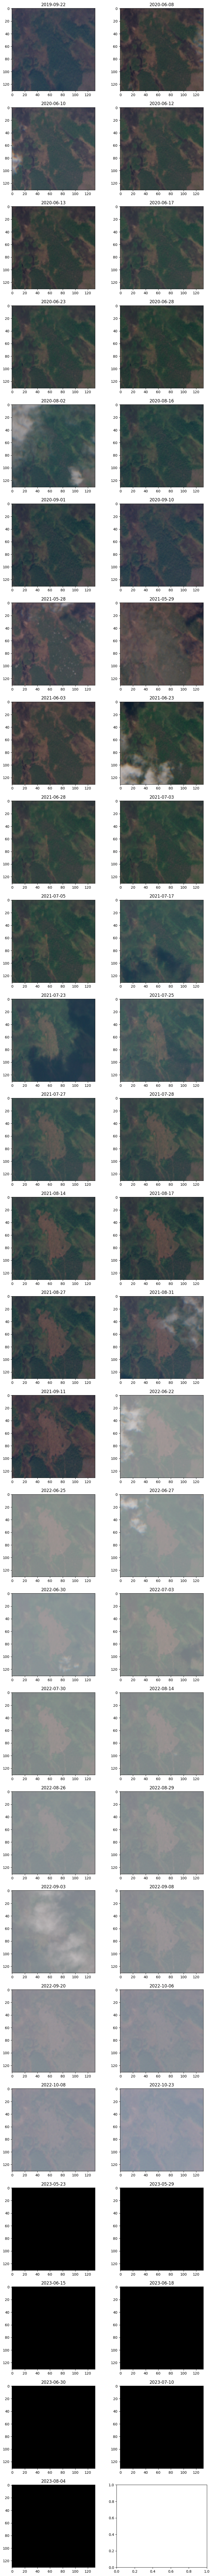

In [183]:
ncols=2
nrows=int(np.ceil(len(temporals)/ncols))

ims_show=[]

plt.rcParams['figure.figsize'] = [5*ncols, 5*nrows]
fig, axs = plt.subplots(ncols=ncols,nrows=nrows)
for i,ax in enumerate(axs.ravel()):
    loaded_data = xr.open_dataset(main_dir+directory+'/'+temporals[i]+'.nc', engine='netcdf4', decode_times=True)
    variables=loaded_data.variables

    b04=variables['b04'].data[0]
    b03=variables['b03'].data[0]
    b02=variables['b02'].data[0]

    b04T=sAdj(b04/10000-ray['r'])
    b03T=sAdj(b03/10000-ray['g'])
    b02T=sAdj(b02/10000-ray['b'])

    rgbLin=satEnh(b04T,b03T,b02T)
    #avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
    for k,p in enumerate(rgbLin[0]):
        for j,q in enumerate(p):
            rgbLin[0][k,j]=sRGB(q)
    for k,p in enumerate(rgbLin[1]):
        for j,q in enumerate(p):
            rgbLin[1][k,j]=sRGB(q)
    for k,p in enumerate(rgbLin[2]):
        for j,q in enumerate(p):
            rgbLin[2][k,j]=sRGB(q)
                
    b04T=rgbLin[0]
    b03T=rgbLin[1]
    b02T=rgbLin[2]

    im=np.zeros((np.shape(b03)[0],np.shape(b03)[1],3))
    im[:,:,0]=b04T
    im[:,:,1]=b03T
    im[:,:,2]=b02T

    ax.imshow(im)#/np.max(im,axis=(0,1)))
    ax.set_title(temporals[i])
    ims_show.append(im)
    

In [184]:
clear_date='2020-08-16'
cloudy_date='2020-08-02'
clear_ind=np.nonzero([st==clear_date for i,st in enumerate(temporals)])[0][0]
cloudy_ind=np.nonzero([st==cloudy_date for i,st in enumerate(temporals)])[0][0]

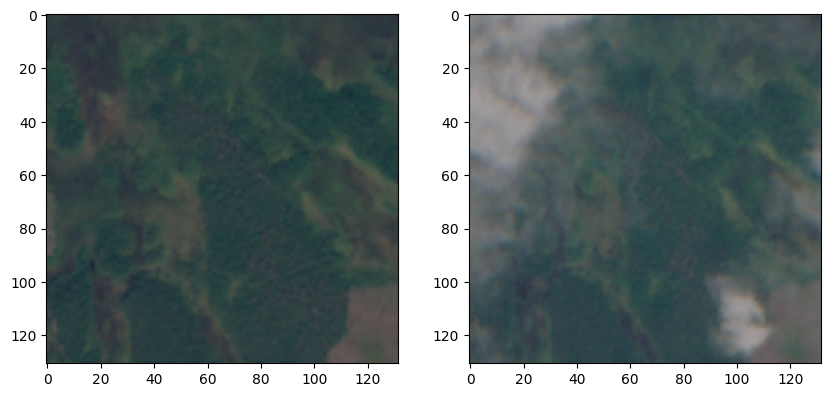

In [185]:
plt.rcParams['figure.figsize'] = [10, 5]
fig,axs=plt.subplots(ncols=2,nrows=1)
axs[0].imshow(ims_show[clear_ind])
axs[1].imshow(ims_show[cloudy_ind])

In [186]:
variables=['b02','b03','b04','b05','b06','b07','b08','b8a','b09','b10','b11','b12']

In [187]:
clear_dataset=xr.open_dataset(main_dir+directory+'/'+clear_date+'.nc', engine='netcdf4', decode_times=True)
cloudy_dataset=xr.open_dataset(main_dir+directory+'/'+cloudy_date+'.nc', engine='netcdf4', decode_times=True)
divide=10000
b02=clear_dataset.variables['b02'].data[0,:,:]/divide
b03=clear_dataset.variables['b03'].data[0,:,:]/divide
b04=clear_dataset.variables['b04'].data[0,:,:]/divide
b05=clear_dataset.variables['b05'].data[0,:,:]/divide
b06=clear_dataset.variables['b06'].data[0,:,:]/divide
b07=clear_dataset.variables['b07'].data[0,:,:]/divide
b08=clear_dataset.variables['b08'].data[0,:,:]/divide
b8a=clear_dataset.variables['b8a'].data[0,:,:]/divide
b09=clear_dataset.variables['b09'].data[0,:,:]/divide
b10=clear_dataset.variables['b10'].data[0,:,:]/divide
b11=clear_dataset.variables['b11'].data[0,:,:]/divide
b12=clear_dataset.variables['b12'].data[0,:,:]/divide


clear_data=np.zeros((np.shape(b12)[0],np.shape(b12)[1],12))
clear_data[:,:,0]=b02
clear_data[:,:,1]=b03
clear_data[:,:,2]=b04
clear_data[:,:,3]=b05
clear_data[:,:,4]=b06
clear_data[:,:,5]=b07
clear_data[:,:,6]=b08
clear_data[:,:,7]=b8a
clear_data[:,:,8]=b09
clear_data[:,:,9]=b10
clear_data[:,:,10]=b11
clear_data[:,:,11]=b12
im_clear=clear_data

b02=cloudy_dataset.variables['b02'].data[0,:,:]/divide
b03=cloudy_dataset.variables['b03'].data[0,:,:]/divide
b04=cloudy_dataset.variables['b04'].data[0,:,:]/divide
b05=cloudy_dataset.variables['b05'].data[0,:,:]/divide
b06=cloudy_dataset.variables['b06'].data[0,:,:]/divide
b07=cloudy_dataset.variables['b07'].data[0,:,:]/divide
b08=cloudy_dataset.variables['b08'].data[0,:,:]/divide
b8a=cloudy_dataset.variables['b8a'].data[0,:,:]/divide
b09=cloudy_dataset.variables['b09'].data[0,:,:]/divide
b10=cloudy_dataset.variables['b10'].data[0,:,:]/divide
b11=cloudy_dataset.variables['b11'].data[0,:,:]/divide
b12=cloudy_dataset.variables['b12'].data[0,:,:]/divide
sun_zen=cloudy_dataset.variables['sun_zenith'].data


cloudy_data=np.zeros((np.shape(b12)[0],np.shape(b12)[1],13))
cloudy_data[:,:,0]=b02
cloudy_data[:,:,1]=b03
cloudy_data[:,:,2]=b04
cloudy_data[:,:,3]=b05
cloudy_data[:,:,4]=b06
cloudy_data[:,:,5]=b07
cloudy_data[:,:,6]=b08
cloudy_data[:,:,7]=b8a
cloudy_data[:,:,8]=b09
cloudy_data[:,:,9]=b10
cloudy_data[:,:,10]=b11
cloudy_data[:,:,11]=b12
cloudy_data[:,:,12]=sun_zen

im_cloud=cloudy_data

In [188]:
import torch

In [206]:
main_filepath='pytorch_models/optuna_optimum'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

In [207]:
im_shape=np.shape(im_cloud)
im_cloud_r=np.zeros((im_shape[0]*im_shape[1],im_shape[2])) #+1 for sun zenith angle
for i in range(im_shape[2]):
    im_cloud_r[:,i]=np.reshape(im_cloud[:,:,i],im_shape[0]*im_shape[1])

In [208]:
from cot_train.utils import StatCollector, MLP5, mlp_inference
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [209]:
model_load_paths=['cot_model/0/model_it_2000000','cot_model/1/model_it_2000000',
                  'cot_model/2/model_it_2000000','cot_model/3/model_it_2000000',
                  'cot_model/4/model_it_2000000']

input_dim = 13
output_dim = 1

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

In [210]:
means=[0.534958,0.538317,0.532992,0.629737,0.826885,0.859306,0.803385,0.880321,0.408178,0.066565,0.428241,0.301306,58.076266]
stds=[0.218962,0.188747,0.236514,0.185751,0.169492,0.170012,0.162448,0.171793,0.237684,0.096908,0.309903,0.202586,15.602082]

inputs = (im_cloud_r - means) / stds

image_input_tens=torch.Tensor(inputs).to(device)
#image_pred_cot=model_cot(image_input_tens).cpu().data.numpy()*50

preds = 0
for model_cot in models_cot:
    curr_preds=model_cot(image_input_tens)/len(models_cot)
    preds=preds+curr_preds

pred_cot=preds.cpu().data.numpy() #unnormalise

## Reshape back
im_pred_cot=np.reshape(pred_cot,im_shape[0:2])*50

t_is_cloud = 0.025*50 # From Alex
t_thin_cloud = 0.015*50 # From Alex

im_pred_cot_t=im_pred_cot.copy()
im_pred_cot_t[im_pred_cot_t<t_thin_cloud]=0
im_pred_cot_t[(im_pred_cot_t>t_thin_cloud)&(im_pred_cot_t<t_is_cloud)]=1
im_pred_cot_t[im_pred_cot_t>t_is_cloud]=2

im_pred_cot_t_r=np.reshape(im_pred_cot_t,im_shape[0]*im_shape[1])

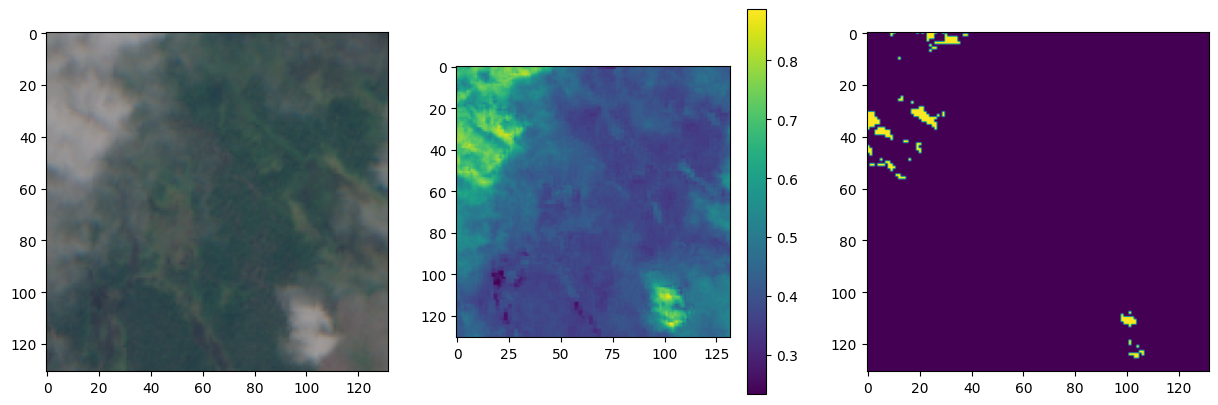

In [211]:
plt.rcParams['figure.figsize'] = [15, 5]
fig,axs =plt.subplots(ncols=3,nrows=1)
axs[0].imshow(ims_show[cloudy_ind])
im_cot=axs[1].imshow(im_pred_cot)
im_cot_2=axs[2].imshow(im_pred_cot_t)
fig.colorbar(im_cot,ax=axs[1])

In [212]:
#One hot encode cot
cot_one_hot=np.zeros((len(im_pred_cot_t_r),3))
cot_one_hot[im_pred_cot_t_r==0,0]=1
cot_one_hot[im_pred_cot_t_r==1,1]=1
cot_one_hot[im_pred_cot_t_r==2,2]=1

## append cot estimation to input data ##
im_cloud_r_c=np.zeros((np.shape(im_cloud_r)[0],np.shape(im_cloud_r)[1]+3))
im_cloud_r_c[:,0:13]=im_cloud_r
im_cloud_r_c[:,13:16]=cot_one_hot

In [213]:
np.shape(im_cloud_r_c)

(17292, 16)

In [214]:

## Make prediction
for i,model in enumerate(models):
    if i==0:
        pred=model.predict(im_cloud_r_c)
    else:   
        pred=pred+model.predict(im_cloud_r_c)
pred=pred/len(models)

In [215]:
##Reshape back
index_median=4
im_shape_pred=(im_shape[0],im_shape[1],12)
im_pred=np.zeros(im_shape_pred)
im_unc=np.zeros(im_shape_pred)
for i in range(im_shape_pred[2]):
    im_pred[:,:,i]=np.reshape(pred[:,i,index_median],im_shape_pred[0:2])
    im_unc[:,:,i]=np.reshape(pred[:,i,-1]-pred[:,i,0],im_shape_pred[0:2])

In [216]:
np.shape(pred)

(17292, 12, 9)

In [217]:
## Get "True" RGB ##
b04Tp=sAdj(im_pred[:,:,2]-ray['r'])
b03Tp=sAdj(im_pred[:,:,1]-ray['g'])
b02Tp=sAdj(im_pred[:,:,0]-ray['b'])

rgbLin=satEnh(b04Tp,b03Tp,b02Tp)
#avgS = ((b04T + b03T + b02T)/3.0) * (1 - sat)
for k,p in enumerate(rgbLin[0]):
    for j,q in enumerate(p):
        rgbLin[0][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[1]):
    for j,q in enumerate(p):
        rgbLin[1][k,j]=sRGB(q)
for k,p in enumerate(rgbLin[2]):
    for j,q in enumerate(p):
        rgbLin[2][k,j]=sRGB(q)

im_pred_show=np.zeros((np.shape(b03)[0],np.shape(b03)[1],3))
im_pred_show[:,:,0]=rgbLin[0]
im_pred_show[:,:,1]=rgbLin[1]
im_pred_show[:,:,2]=rgbLin[2]

Text(0.5, 1.0, 'Predicted Image')

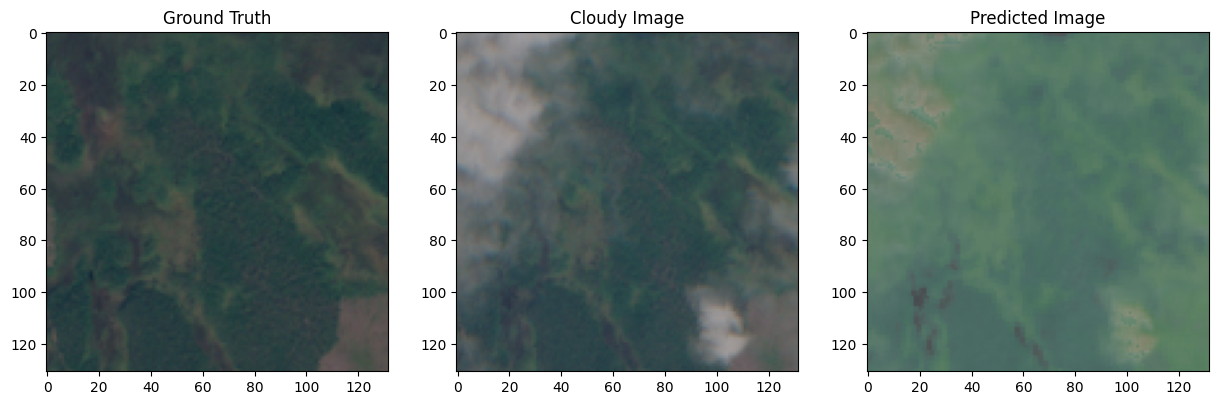

In [218]:
plt.rcParams['figure.figsize'] = [15, 5]
fig,axs=plt.subplots(ncols=3,nrows=1)
axs[0].imshow(ims_show[clear_ind])
axs[0].set_title("Ground Truth")
axs[1].imshow(ims_show[cloudy_ind])
axs[1].set_title("Cloudy Image")
axs[2].imshow(im_pred_show)
axs[2].set_title("Predicted Image")

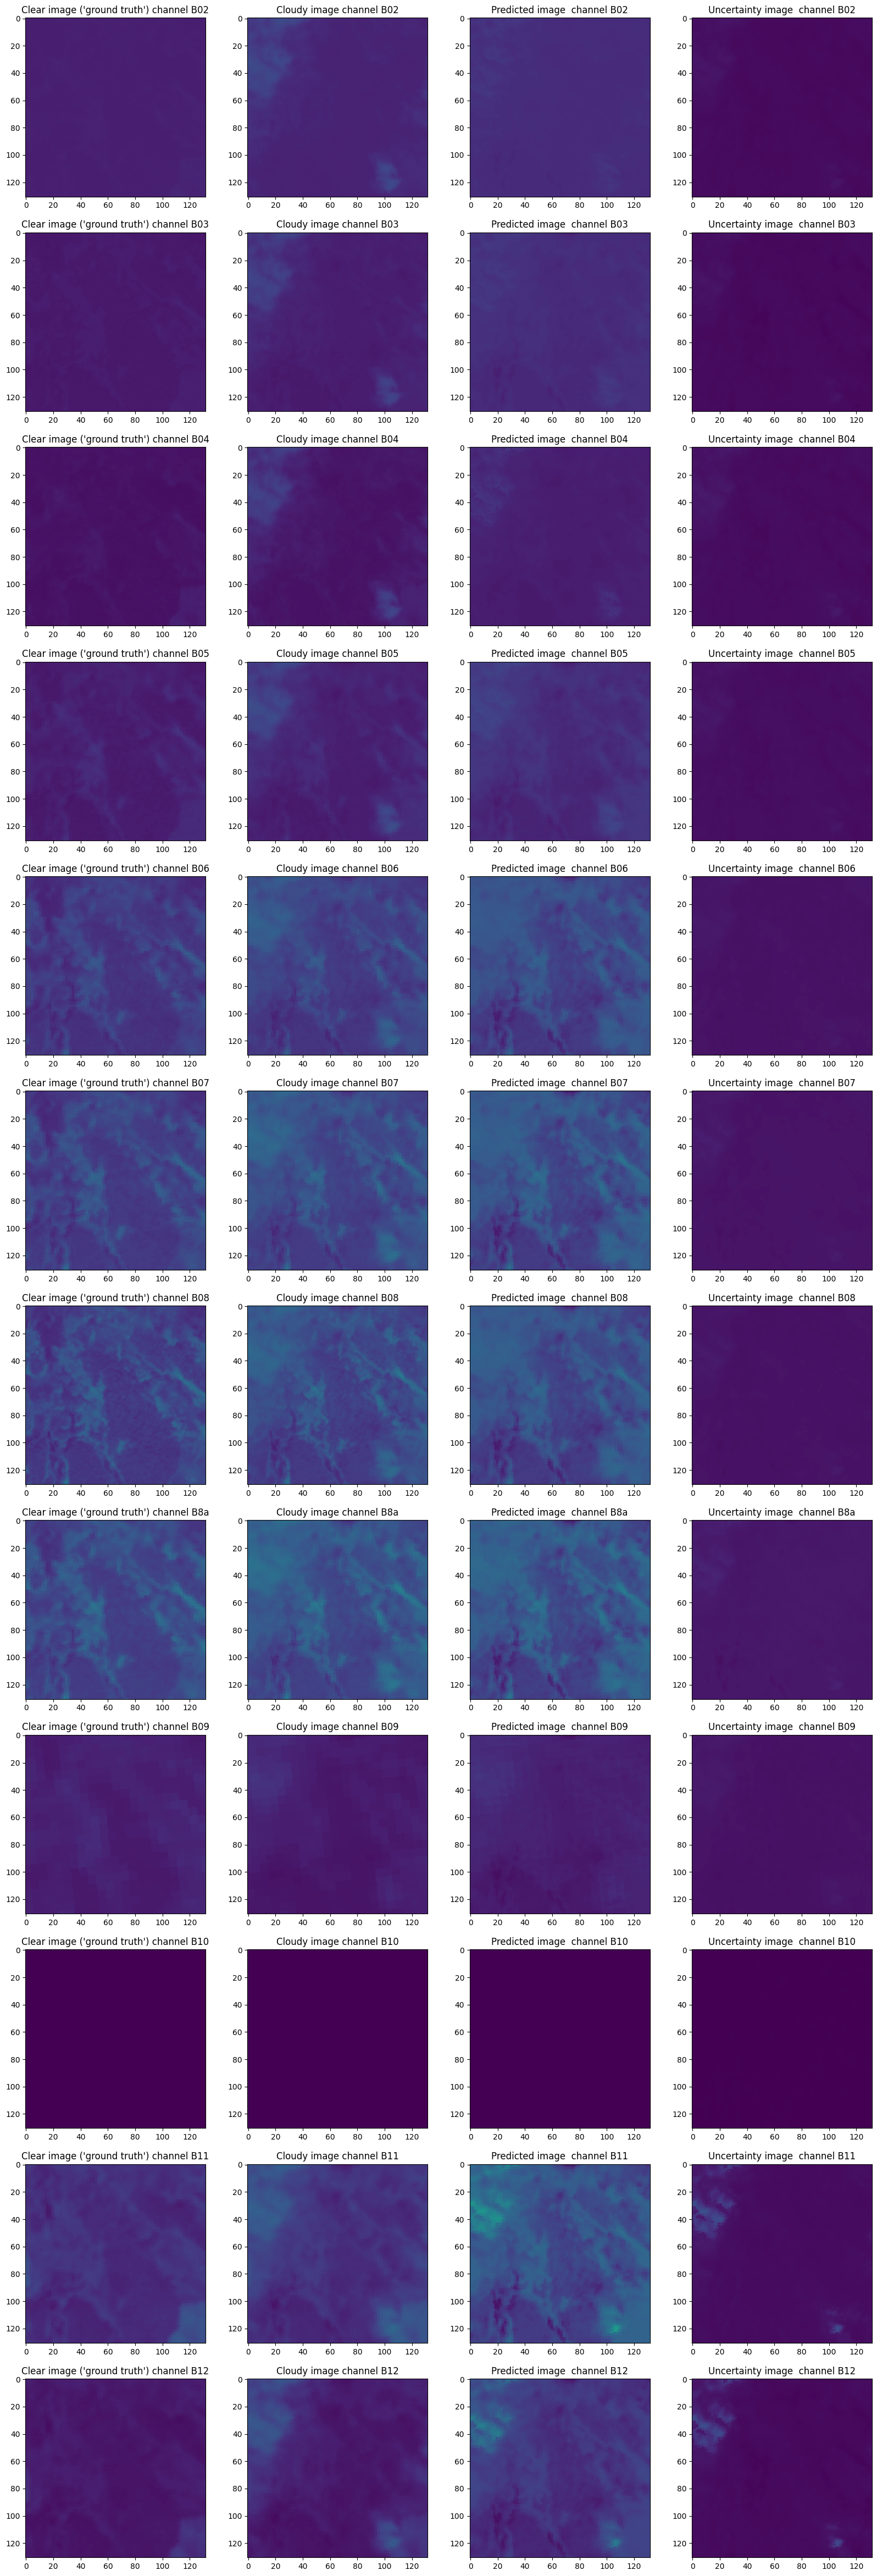

In [219]:
nchannels=12
plt.rcParams['figure.figsize'] = [20, 5*nchannels]
fig,axs=plt.subplots(ncols=4,nrows=nchannels)
for i in range(nchannels):
    axs[i,0].imshow(im_clear[:,:,i],vmin=0,vmax=1)
    axs[i,1].imshow(im_cloud[:,:,i],vmin=0,vmax=1)
    im_tmp=axs[i,2].imshow(im_pred[:,:,i],vmin=0,vmax=1)
    
    axs[i,3].imshow(im_unc[:,:,i],vmin=0,vmax=1)
    

    if i<7:
        axs[i,0].set_title("Clear image ('ground truth') channel B0"+str(i+2))
        axs[i,1].set_title("Cloudy image channel B0"+str(i+2))
        axs[i,2].set_title("Predicted image  channel B0"+str(i+2))
        axs[i,3].set_title("Uncertainty image  channel B0"+str(i+2))
    elif i==7:
        axs[i,0].set_title("Clear image ('ground truth') channel B8a")
        axs[i,1].set_title("Cloudy image channel B8a")
        axs[i,2].set_title("Predicted image  channel B8a")
        axs[i,3].set_title("Uncertainty image  channel B8a")
    elif i==8:
        axs[i,0].set_title("Clear image ('ground truth') channel B0"+str(i+1))
        axs[i,1].set_title("Cloudy image channel B0"+str(i+1))
        axs[i,2].set_title("Predicted image  channel B0"+str(i+1))
        axs[i,3].set_title("Uncertainty image  channel B0"+str(i+1))
    else:
        axs[i,0].set_title("Clear image ('ground truth') channel B"+str(i+1))
        axs[i,1].set_title("Cloudy image channel B"+str(i+1))
        axs[i,2].set_title("Predicted image  channel B"+str(i+1))
        axs[i,3].set_title("Uncertainty image  channel B"+str(i+1))

In [220]:
np.shape(im_cloud)

(131, 132, 13)

In [221]:
#np.linal.norm() -> Frobenius norm i.e root of the sum of squares
norm_og=np.linalg.norm(np.square((im_clear)-(im_cloud[:,:,0:12])),axis=(0,1))**2
norm_pred=np.linalg.norm(np.square((im_clear)-im_pred),axis=(0,1))**2
norm_gt=np.linalg.norm(np.square(im_clear),axis=(0,1))**2

NMSE_og=norm_og/norm_gt
NMSE_pred=norm_pred/norm_gt

In [222]:
for i in range(len(NMSE_og)):
    if i<=6:
        print('NMSE before correction, Band '+str(i+2)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+2)+': '+str(NMSE_pred[i]))
    elif i==7:
        print('NMSE before correction, Band '+str(i+1)+'A: '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+'A: '+str(NMSE_pred[i]))
    else:
        print('NMSE before correction, Band '+str(i+1)+': '+str(NMSE_og[i]))
        print('NMSE after correction, Band '+str(i+1)+': '+str(NMSE_pred[i]))    

    print(' ')

NMSE before correction, Band 2: 0.22702468709838317
NMSE after correction, Band 2: 0.06206387582607781
 
NMSE before correction, Band 3: 0.46855697031578597
NMSE after correction, Band 3: 0.5335398208078587
 
NMSE before correction, Band 4: 2.5339325758007134
NMSE after correction, Band 4: 0.633413766778949
 
NMSE before correction, Band 5: 0.29834670318405637
NMSE after correction, Band 5: 0.27441665839091034
 
NMSE before correction, Band 6: 0.04038732852332763
NMSE after correction, Band 6: 0.04759653129622135
 
NMSE before correction, Band 7: 0.028886644653270968
NMSE after correction, Band 7: 0.02593052657631165
 
NMSE before correction, Band 8: 0.021381997406637054
NMSE after correction, Band 8: 0.02216467429248112
 
NMSE before correction, Band 8A: 0.01875812521438746
NMSE after correction, Band 8A: 0.014090130390228339
 
NMSE before correction, Band 9: 0.008769556598153583
NMSE after correction, Band 9: 0.008741409129593853
 
NMSE before correction, Band 10: 0.5874807650699329
